In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def cheb_steps(m, M, T):
    C, R = (M+m)/2., (M-m)/2.
    thetas = (np.arange(T)+0.5)/T * np.pi
    return 1./(C - R*np.cos(thetas))

def cheb_perm(T):
    perm = np.array([0])
    while len(perm) < T:
        perm = np.vstack([perm, 2*len(perm)-1-perm]).T.flatten()
    return perm

In [4]:
def evaluate_classification_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    
    return accuracy, precision, recall, f1, true_labels, predictions

In [5]:
def evaluate_regression_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.to(device))
            predictions.extend(outputs.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())

    predictions = [0 if np.isnan(x) else x for x in predictions]
    true_labels = [0 if np.isnan(x) else x for x in true_labels]
    
    mse = mean_squared_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    
    return mse, r2

In [6]:
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def plot_curves(epoch_losses, epoch_accuracies):
    epochs = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_losses, 'r-', label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_accuracies, 'b-', label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()

In [8]:
def plot_learning_rates(epoch_learning_rates):
    epochs = range(1, len(epoch_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, epoch_learning_rates, 'g-', label='Learning Rates')
    plt.title('Learning Rates')
    plt.xlabel('Epoch')
    plt.ylabel('Learing Rate')
    plt.legend()

## CIFAR10 Experiment

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def create_resnet18():
    model = models.resnet18(weights=None)
    model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = torch.nn.Identity()
    return model

### Control Model

In [11]:
cifar_control = create_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_control.parameters(), lr=0.2)

epoch_losses = []
epoch_accuracies = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    cifar_control.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = cifar_control(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(cifar_control.state_dict(), 'cifar_control.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 1.9702, Accuracy: 35.20%, Time: 28.73 sec
Epoch 2, Loss: 1.2325, Accuracy: 54.87%, Time: 27.81 sec
Epoch 3, Loss: 0.9365, Accuracy: 66.48%, Time: 27.85 sec
Epoch 4, Loss: 0.7357, Accuracy: 73.76%, Time: 27.87 sec
Epoch 5, Loss: 0.5627, Accuracy: 80.01%, Time: 27.91 sec
Epoch 6, Loss: 0.4165, Accuracy: 85.31%, Time: 27.90 sec
Epoch 7, Loss: 0.2862, Accuracy: 89.87%, Time: 27.96 sec
Epoch 8, Loss: 0.1695, Accuracy: 94.19%, Time: 27.98 sec
Epoch 9, Loss: 0.1178, Accuracy: 95.89%, Time: 27.90 sec
Epoch 10, Loss: 0.0728, Accuracy: 97.62%, Time: 27.95 sec
Epoch 11, Loss: 0.0349, Accuracy: 98.96%, Time: 27.89 sec
Epoch 12, Loss: 0.0174, Accuracy: 99.51%, Time: 27.98 sec
Epoch 13, Loss: 0.0062, Accuracy: 99.88%, Time: 27.98 sec
Epoch 14, Loss: 0.0017, Accuracy: 99.99%, Time: 27.88 sec
Epoch 15, Loss: 0.0007, Accuracy: 100.00%, Time: 28.22 sec
Epoch 16, Loss: 0.0004, Accuracy: 100.00%, Time: 27.92 sec
Epoch 17, Loss: 0.0003, Accuracy: 100.00%, Time: 27.88 sec
Epoch 18, Loss: 0.00

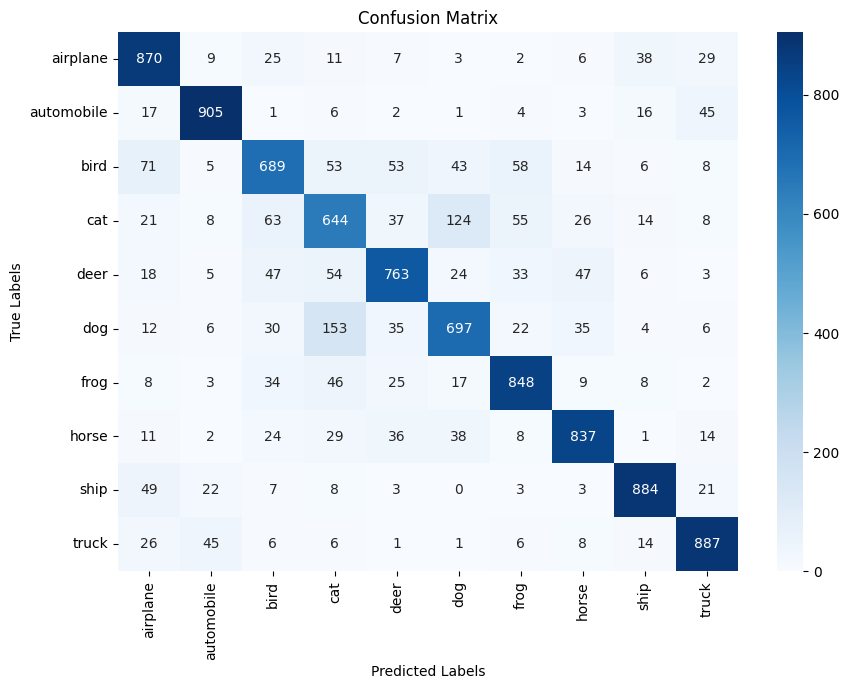

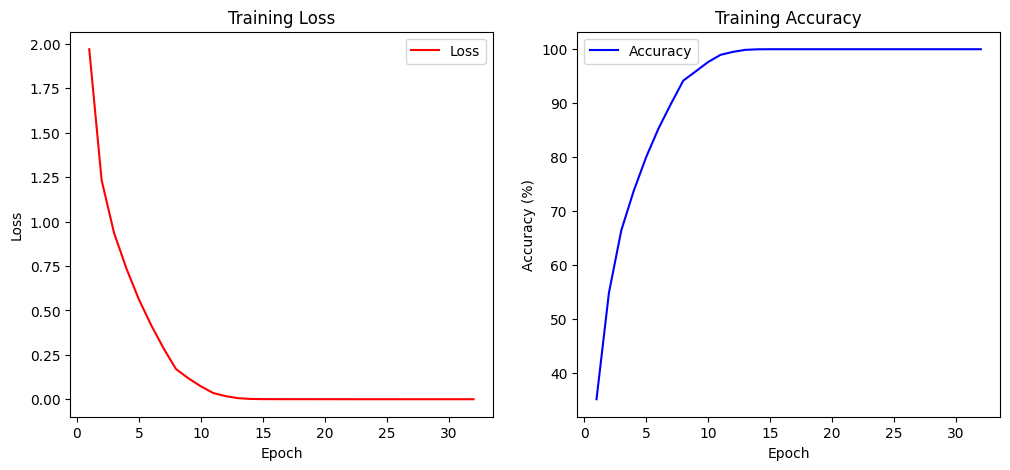

0.8024 0.8017274448407162 0.8024000000000001 0.8016283037408565


In [12]:
eval_model = create_resnet18().to(device)
eval_model.load_state_dict(torch.load('cifar_control.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

print(accuracy, precision, recall, f1)

### Decay Model

In [13]:
cifar_decay = create_resnet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cifar_decay.parameters(), lr=0.3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.90)

epoch_losses = []
epoch_accuracies = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    cifar_decay.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = cifar_decay(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    lr = scheduler.get_last_lr()
    epoch_learning_rates.append(lr[0])
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(cifar_decay.state_dict(), 'cifar_decay.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 2.1159, Accuracy: 31.57%, Time: 27.85 sec
Epoch 2, Loss: 1.3552, Accuracy: 50.04%, Time: 27.87 sec
Epoch 3, Loss: 1.0679, Accuracy: 61.49%, Time: 27.89 sec
Epoch 4, Loss: 0.8583, Accuracy: 69.32%, Time: 27.93 sec
Epoch 5, Loss: 0.6807, Accuracy: 75.76%, Time: 28.01 sec
Epoch 6, Loss: 0.4944, Accuracy: 82.48%, Time: 28.02 sec
Epoch 7, Loss: 0.3258, Accuracy: 88.74%, Time: 28.56 sec
Epoch 8, Loss: 0.1759, Accuracy: 94.34%, Time: 27.98 sec
Epoch 9, Loss: 0.0741, Accuracy: 97.96%, Time: 27.96 sec
Epoch 10, Loss: 0.0248, Accuracy: 99.53%, Time: 27.92 sec
Epoch 11, Loss: 0.0095, Accuracy: 99.87%, Time: 27.95 sec
Epoch 12, Loss: 0.0055, Accuracy: 99.93%, Time: 27.95 sec
Epoch 13, Loss: 0.0043, Accuracy: 99.95%, Time: 27.95 sec
Epoch 14, Loss: 0.0027, Accuracy: 99.98%, Time: 28.00 sec
Epoch 15, Loss: 0.0018, Accuracy: 100.00%, Time: 28.03 sec
Epoch 16, Loss: 0.0017, Accuracy: 100.00%, Time: 28.00 sec
Epoch 17, Loss: 0.0033, Accuracy: 99.97%, Time: 27.93 sec
Epoch 18, Loss: 0.001

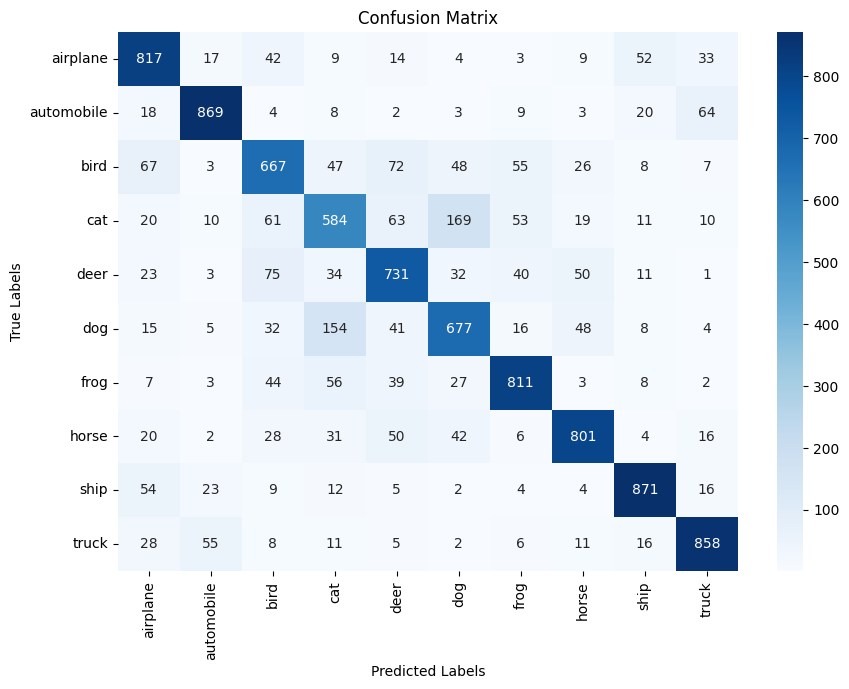

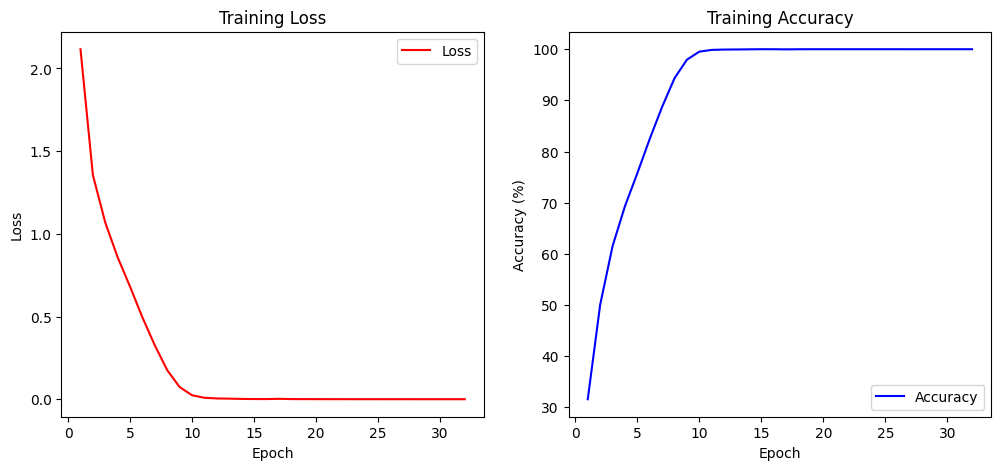

0.7686 0.7678086696818769 0.7686 0.7680245157191272


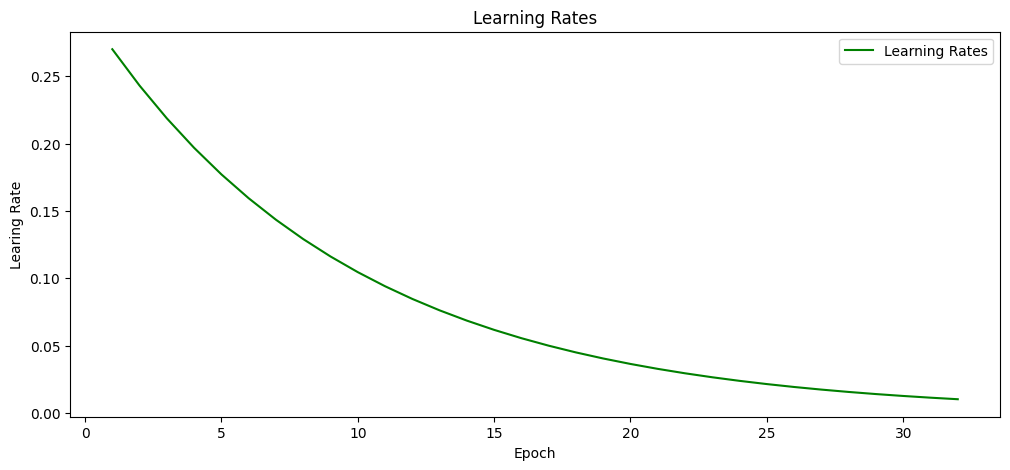

In [14]:
eval_model = create_resnet18().to(device)
eval_model.load_state_dict(torch.load('cifar_decay.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

plot_learning_rates(epoch_learning_rates)

print(accuracy, precision, recall, f1)

### Experimental Model

In [15]:
cifar_experimental = create_resnet18().to(device)
optimizer = optim.SGD(cifar_experimental.parameters(), lr=0.2)
criterion = nn.CrossEntropyLoss()

m, M, T = 0.45, 1, 2**7
steps = cheb_steps(m, M, T)
perm = cheb_perm(T)
permuted_steps = steps[perm]

epoch_losses = []
epoch_accuracies = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    cifar_experimental.train()
    
    lr = permuted_steps[epoch % T]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = cifar_experimental(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    epoch_learning_rates.append(lr)
    
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(cifar_experimental.state_dict(), 'cifar_experimental.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 3.0090, Accuracy: 18.40%, Time: 25.52 sec
Epoch 2, Loss: 1.7177, Accuracy: 35.78%, Time: 25.51 sec
Epoch 3, Loss: 1.6014, Accuracy: 40.37%, Time: 25.49 sec
Epoch 4, Loss: 1.4581, Accuracy: 46.08%, Time: 25.50 sec
Epoch 5, Loss: 1.3939, Accuracy: 48.71%, Time: 25.50 sec
Epoch 6, Loss: 1.1847, Accuracy: 57.04%, Time: 25.48 sec
Epoch 7, Loss: 1.1909, Accuracy: 56.77%, Time: 25.46 sec
Epoch 8, Loss: 0.9665, Accuracy: 65.46%, Time: 25.45 sec
Epoch 9, Loss: 1.0294, Accuracy: 63.21%, Time: 25.49 sec
Epoch 10, Loss: 0.7588, Accuracy: 73.06%, Time: 25.50 sec
Epoch 11, Loss: 0.7623, Accuracy: 72.71%, Time: 25.47 sec
Epoch 12, Loss: 0.6118, Accuracy: 78.46%, Time: 25.49 sec
Epoch 13, Loss: 0.6742, Accuracy: 76.00%, Time: 25.49 sec
Epoch 14, Loss: 0.4138, Accuracy: 85.28%, Time: 25.46 sec
Epoch 15, Loss: 0.4420, Accuracy: 84.20%, Time: 25.48 sec
Epoch 16, Loss: 0.2834, Accuracy: 90.11%, Time: 25.48 sec
Epoch 17, Loss: 0.4389, Accuracy: 84.45%, Time: 25.48 sec
Epoch 18, Loss: 0.1594,

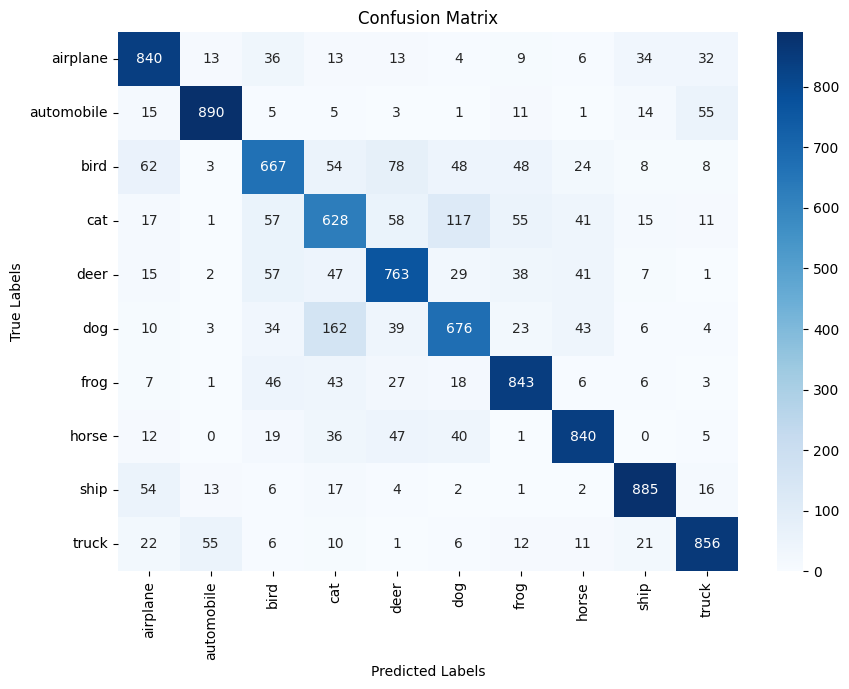

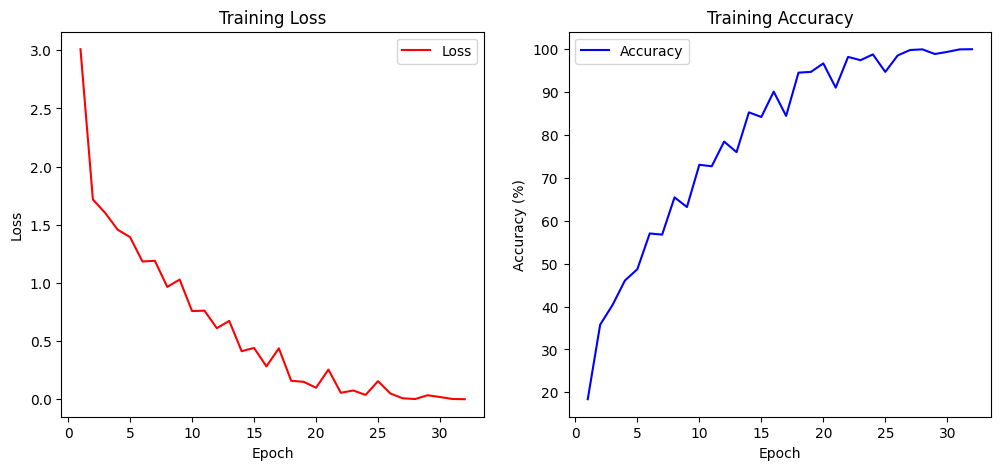

0.7888 0.7884541569854172 0.7888 0.7883514939647477


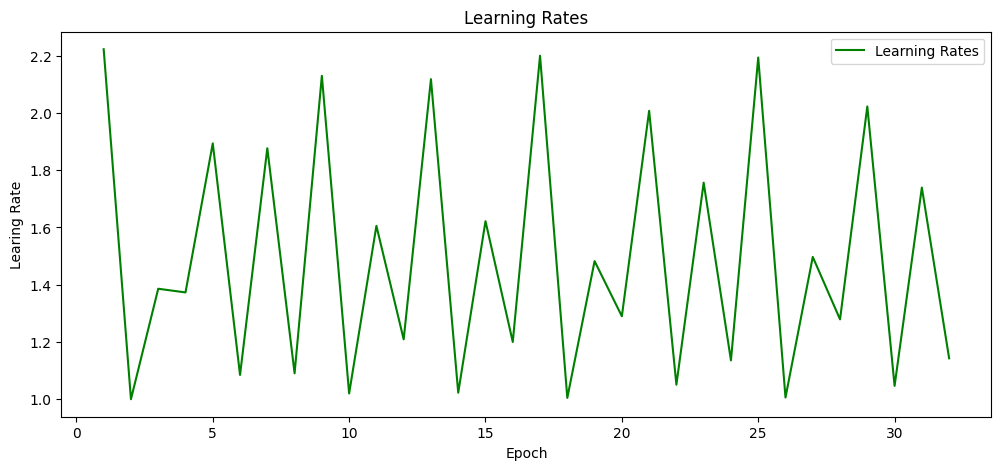

In [16]:
eval_model = create_resnet18().to(device)
eval_model.load_state_dict(torch.load('cifar_experimental.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

plot_learning_rates(epoch_learning_rates)

print(accuracy, precision, recall, f1)

## MNIST Experiment

In [33]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

In [34]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### Control Model

In [51]:
mnist_control = MNIST_CNN().to(device)
optimizer = optim.SGD(mnist_control.parameters(), lr=0.1)
criterion = nn.NLLLoss()

epoch_losses = []
epoch_accuracies = []

start_time = time.time()

for epoch in range(10):
    epoch_start_time = time.time()
    
    mnist_control.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mnist_control(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(mnist_control.state_dict(), 'mnist_control.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 0.9939, Accuracy: 72.31%, Time: 8.84 sec
Epoch 2, Loss: 0.1812, Accuracy: 94.48%, Time: 9.27 sec
Epoch 3, Loss: 0.1135, Accuracy: 96.56%, Time: 9.59 sec
Epoch 4, Loss: 0.0894, Accuracy: 97.25%, Time: 9.31 sec
Epoch 5, Loss: 0.0729, Accuracy: 97.78%, Time: 9.17 sec
Epoch 6, Loss: 0.0624, Accuracy: 98.09%, Time: 9.39 sec
Epoch 7, Loss: 0.0550, Accuracy: 98.34%, Time: 9.40 sec
Epoch 8, Loss: 0.0498, Accuracy: 98.47%, Time: 9.30 sec
Epoch 9, Loss: 0.0458, Accuracy: 98.64%, Time: 9.40 sec
Epoch 10, Loss: 0.0416, Accuracy: 98.73%, Time: 9.21 sec
Total training time: 92.90 seconds


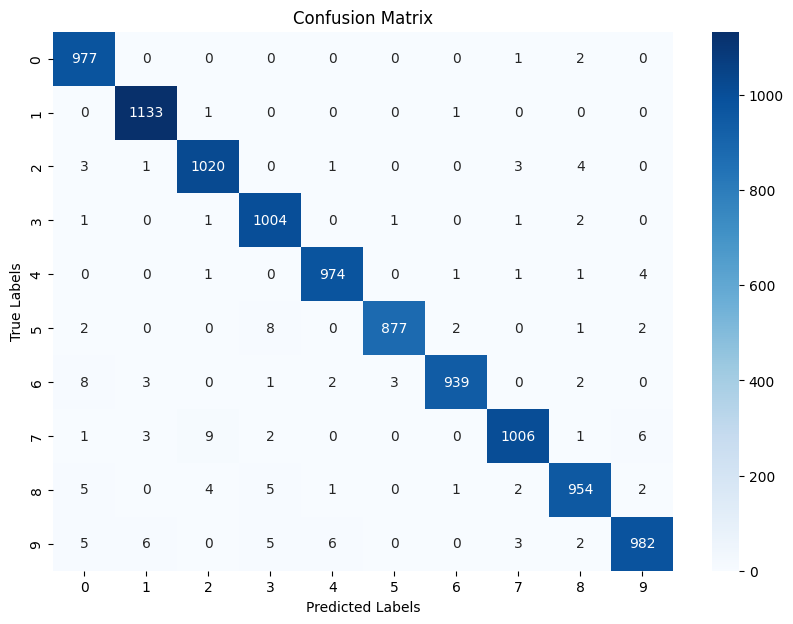

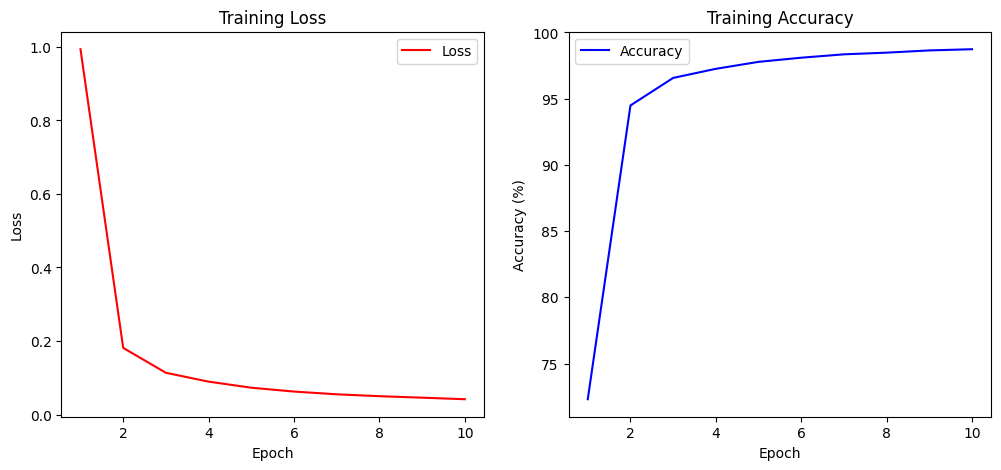

0.9866 0.9867422541504363 0.9864118564935254 0.9865399906407802


In [52]:
eval_model = MNIST_CNN().to(device)
eval_model.load_state_dict(torch.load('mnist_control.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

print(accuracy, precision, recall, f1)

### Decay Model

In [43]:
mnist_decay = MNIST_CNN().to(device)
optimizer = optim.SGD(mnist_decay.parameters(), lr=0.2)
criterion = nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

epoch_losses = []
epoch_accuracies = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(10):
    epoch_start_time = time.time()
    
    mnist_decay.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mnist_decay(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    lr = scheduler.get_last_lr()
    epoch_learning_rates.append(lr[0])
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(mnist_decay.state_dict(), 'mnist_decay.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 1.2545, Accuracy: 63.56%, Time: 8.62 sec
Epoch 2, Loss: 0.1394, Accuracy: 95.76%, Time: 9.25 sec
Epoch 3, Loss: 0.0855, Accuracy: 97.31%, Time: 9.29 sec
Epoch 4, Loss: 0.0680, Accuracy: 97.86%, Time: 9.47 sec
Epoch 5, Loss: 0.0561, Accuracy: 98.26%, Time: 9.52 sec
Epoch 6, Loss: 0.0487, Accuracy: 98.50%, Time: 9.28 sec
Epoch 7, Loss: 0.0431, Accuracy: 98.67%, Time: 9.53 sec
Epoch 8, Loss: 0.0387, Accuracy: 98.84%, Time: 9.49 sec
Epoch 9, Loss: 0.0353, Accuracy: 98.91%, Time: 9.54 sec
Epoch 10, Loss: 0.0323, Accuracy: 99.06%, Time: 9.99 sec
Total training time: 94.01 seconds


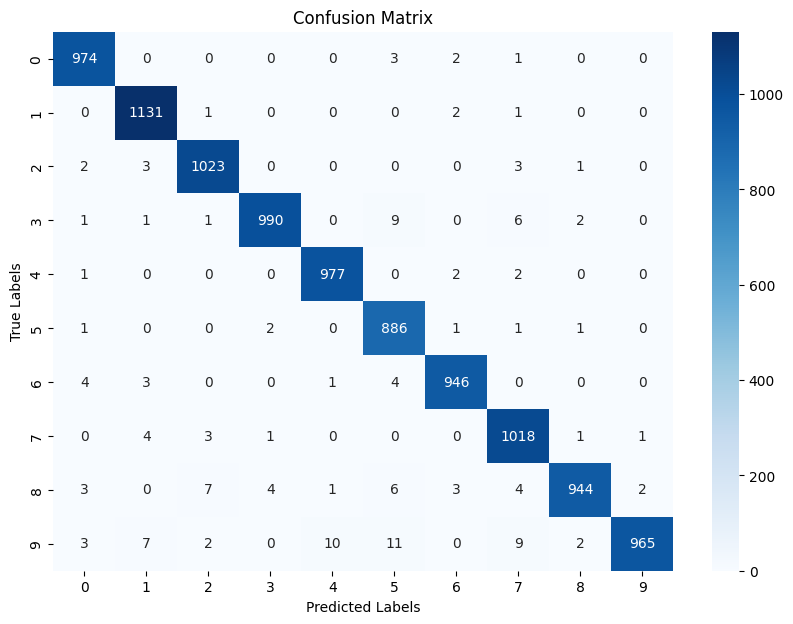

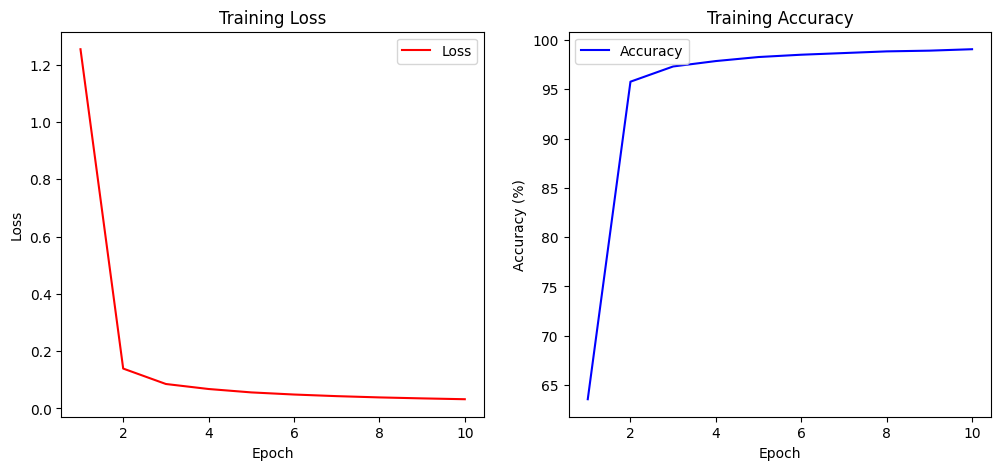

0.9854 0.9853846340518955 0.9853350228363444 0.9852635985551922


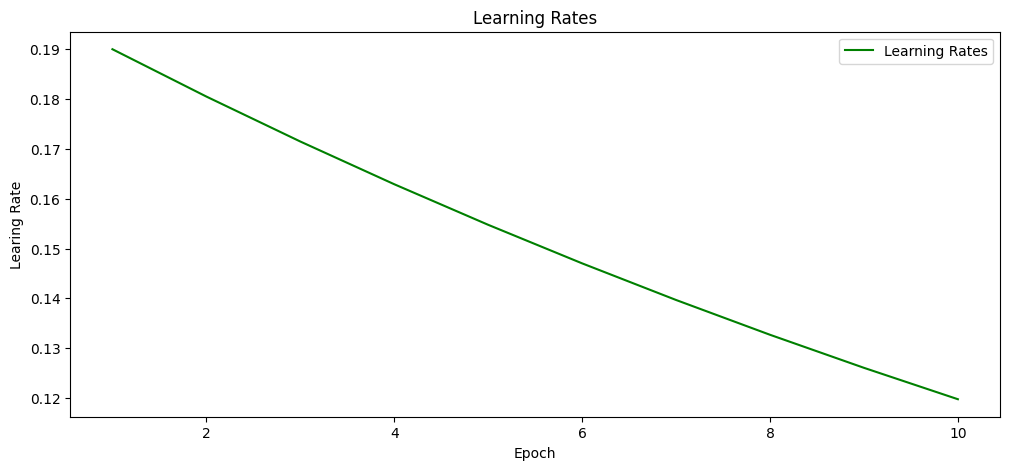

In [44]:
eval_model = MNIST_CNN().to(device)
eval_model.load_state_dict(torch.load('mnist_decay.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

plot_learning_rates(epoch_learning_rates)

print(accuracy, precision, recall, f1)

### Experimental Model

In [45]:
mnist_experimental = MNIST_CNN().to(device)
optimizer = optim.SGD(mnist_experimental.parameters(), lr=0.01)
criterion = nn.NLLLoss()

m, M, T = 4.08, 7.85, 2**3
steps = cheb_steps(m, M, T)
perm = cheb_perm(T)
permuted_steps = steps[perm]

epoch_losses = []
epoch_accuracies = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(10):
    epoch_start_time = time.time()
    
    mnist_experimental.train()
    
    lr = permuted_steps[epoch % T]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mnist_experimental(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    epoch_learning_rates.append(lr)
    
    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} sec')

torch.save(mnist_experimental.state_dict(), 'mnist_experimental.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 1.8238, Accuracy: 47.41%, Time: 9.49 sec
Epoch 2, Loss: 0.2388, Accuracy: 92.51%, Time: 9.36 sec
Epoch 3, Loss: 0.1468, Accuracy: 95.23%, Time: 8.85 sec
Epoch 4, Loss: 0.0915, Accuracy: 97.18%, Time: 9.39 sec
Epoch 5, Loss: 0.2433, Accuracy: 93.17%, Time: 9.36 sec
Epoch 6, Loss: 0.0750, Accuracy: 97.64%, Time: 9.19 sec
Epoch 7, Loss: 0.0648, Accuracy: 98.04%, Time: 9.54 sec
Epoch 8, Loss: 0.0535, Accuracy: 98.39%, Time: 9.43 sec
Epoch 9, Loss: 0.0532, Accuracy: 98.35%, Time: 9.82 sec
Epoch 10, Loss: 0.0408, Accuracy: 98.76%, Time: 9.40 sec
Total training time: 93.86 seconds


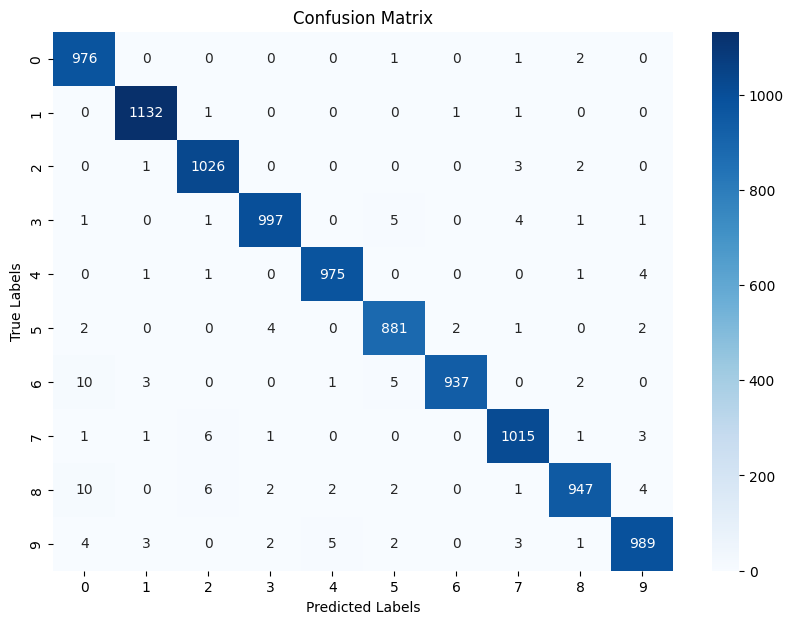

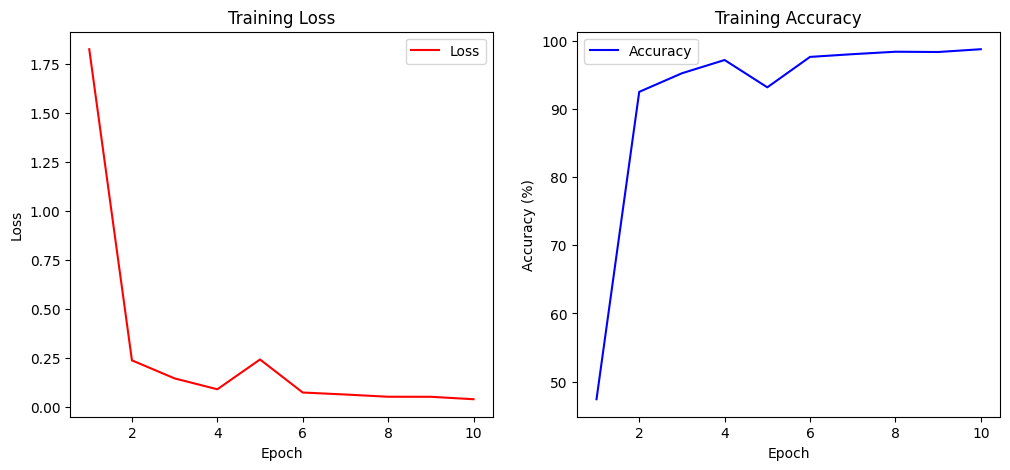

0.9875 0.9874784390743334 0.987302087956126 0.9873550175089054


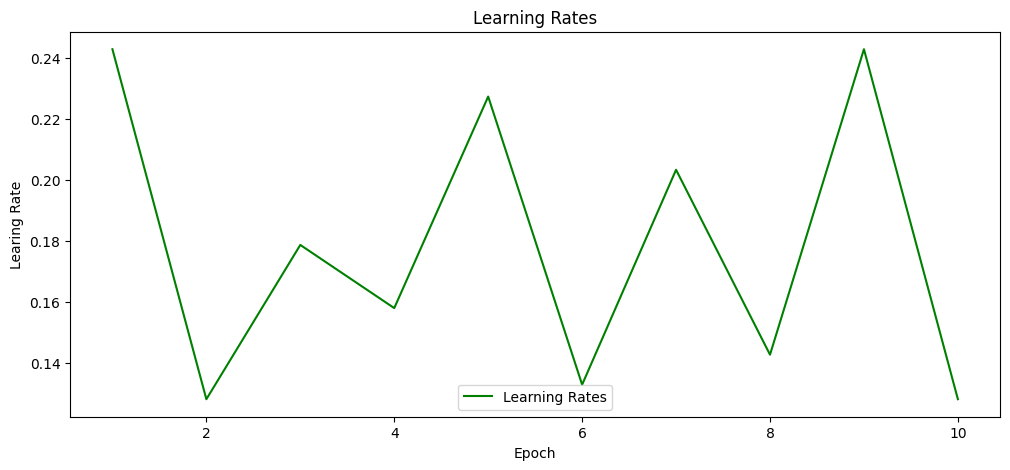

In [46]:
eval_model = MNIST_CNN().to(device)
eval_model.load_state_dict(torch.load('mnist_experimental.pth'))

accuracy, precision, recall, f1, true_labels, predictions = evaluate_classification_model(eval_model, testloader)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(true_labels, predictions, class_names)

plot_curves(epoch_losses, epoch_accuracies)

plot_learning_rates(epoch_learning_rates)

print(accuracy, precision, recall, f1)

## California Housing Model

In [9]:
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

traindataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(traindataset, batch_size=32, shuffle=True)

testdataset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testdataset, batch_size=32, shuffle=False)

In [10]:
class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        self.fc1 = nn.Linear(in_features=8, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.output_layer = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output_layer(x)
        return x

### Control Model

In [11]:
housing_control = HousingModel().to(device)
optimizer = optim.SGD(housing_control.parameters(), lr=0.008)
criterion = nn.MSELoss()

epoch_losses = []
epoch_r2_scores = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    housing_control.train()
    
    running_loss = 0.0
    predictions_list = []
    labels_list = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = housing_control(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions_list.extend(outputs.view(-1).detach().cpu().numpy())
        labels_list.extend(labels.view(-1).detach().cpu().numpy())
    
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)

    mse = mean_squared_error(labels_list, predictions_list)
    r2 = r2_score(labels_list, predictions_list)
    epoch_r2_scores.append(r2)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, MSE: {mse:.4f}, R^2 Score: {r2:.4f}, Time: {epoch_time:.2f} sec')

torch.save(housing_control.state_dict(), 'housing_control.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 0.8103, MSE: 0.8103, R^2 Score: 0.3938, Time: 0.92 sec
Epoch 2, Loss: 0.4786, MSE: 0.4786, R^2 Score: 0.6419, Time: 0.69 sec
Epoch 3, Loss: 0.4384, MSE: 0.4384, R^2 Score: 0.6720, Time: 0.70 sec
Epoch 4, Loss: 0.4160, MSE: 0.4160, R^2 Score: 0.6888, Time: 0.73 sec
Epoch 5, Loss: 0.3986, MSE: 0.3986, R^2 Score: 0.7018, Time: 1.00 sec
Epoch 6, Loss: 0.3841, MSE: 0.3841, R^2 Score: 0.7127, Time: 0.87 sec
Epoch 7, Loss: 0.3716, MSE: 0.3716, R^2 Score: 0.7220, Time: 0.85 sec
Epoch 8, Loss: 0.3608, MSE: 0.3608, R^2 Score: 0.7301, Time: 0.91 sec
Epoch 9, Loss: 0.3510, MSE: 0.3510, R^2 Score: 0.7375, Time: 0.97 sec
Epoch 10, Loss: 0.3451, MSE: 0.3451, R^2 Score: 0.7418, Time: 0.98 sec
Epoch 11, Loss: 0.3377, MSE: 0.3377, R^2 Score: 0.7474, Time: 0.97 sec
Epoch 12, Loss: 0.3323, MSE: 0.3323, R^2 Score: 0.7514, Time: 1.02 sec
Epoch 13, Loss: 0.3269, MSE: 0.3269, R^2 Score: 0.7554, Time: 0.93 sec
Epoch 14, Loss: 0.3238, MSE: 0.3238, R^2 Score: 0.7578, Time: 0.93 sec
Epoch 15, Loss:

Test MSE: 0.29844900965690613
Test R^2 Score: 0.7722474330528661


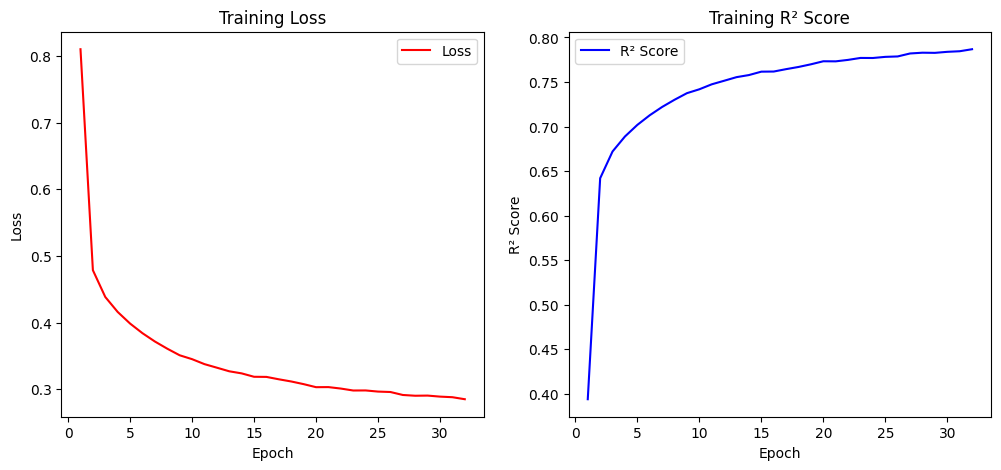

In [12]:
eval_model = HousingModel().to(device)
eval_model.load_state_dict(torch.load('housing_control.pth'))

mse, r2 = evaluate_regression_model(eval_model, testloader)
print(f"Test MSE: {mse}")
print(f"Test R^2 Score: {r2}")

epochs = range(1, len(epoch_losses) + 1)
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, 'r-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_r2_scores, 'b-', label='R² Score')
plt.title(f'Training R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.show()

### Decay Model

In [13]:
housing_decay = HousingModel().to(device)
optimizer = optim.SGD(housing_decay.parameters(), lr=0.01)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epoch_losses = []
epoch_r2_scores = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    housing_decay.train()
    
    running_loss = 0.0
    predictions_list = []
    labels_list = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = housing_decay(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions_list.extend(outputs.view(-1).detach().cpu().numpy())
        labels_list.extend(labels.view(-1).detach().cpu().numpy())
    
    scheduler.step()
    lr = scheduler.get_last_lr()
    epoch_learning_rates.append(lr[0])
    
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)

    mse = mean_squared_error(labels_list, predictions_list)
    r2 = r2_score(labels_list, predictions_list)
    epoch_r2_scores.append(r2)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, MSE: {mse:.4f}, R^2 Score: {r2:.4f}, Time: {epoch_time:.2f} sec')

torch.save(housing_decay.state_dict(), 'housing_decay.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 0.7266, MSE: 0.7266, R^2 Score: 0.4565, Time: 0.91 sec
Epoch 2, Loss: 0.4381, MSE: 0.4381, R^2 Score: 0.6723, Time: 1.08 sec
Epoch 3, Loss: 0.4080, MSE: 0.4080, R^2 Score: 0.6948, Time: 1.01 sec
Epoch 4, Loss: 0.3915, MSE: 0.3915, R^2 Score: 0.7071, Time: 0.94 sec
Epoch 5, Loss: 0.3750, MSE: 0.3750, R^2 Score: 0.7194, Time: 0.92 sec
Epoch 6, Loss: 0.3627, MSE: 0.3627, R^2 Score: 0.7287, Time: 1.28 sec
Epoch 7, Loss: 0.3540, MSE: 0.3540, R^2 Score: 0.7352, Time: 1.15 sec
Epoch 8, Loss: 0.3473, MSE: 0.3473, R^2 Score: 0.7402, Time: 0.89 sec
Epoch 9, Loss: 0.3415, MSE: 0.3415, R^2 Score: 0.7445, Time: 1.04 sec
Epoch 10, Loss: 0.3375, MSE: 0.3375, R^2 Score: 0.7475, Time: 0.89 sec
Epoch 11, Loss: 0.3333, MSE: 0.3333, R^2 Score: 0.7506, Time: 1.26 sec
Epoch 12, Loss: 0.3295, MSE: 0.3295, R^2 Score: 0.7535, Time: 0.97 sec
Epoch 13, Loss: 0.3265, MSE: 0.3265, R^2 Score: 0.7558, Time: 0.96 sec
Epoch 14, Loss: 0.3242, MSE: 0.3242, R^2 Score: 0.7575, Time: 1.13 sec
Epoch 15, Loss:

Test MSE: 0.31865811347961426
Test R^2 Score: 0.7568254502329717


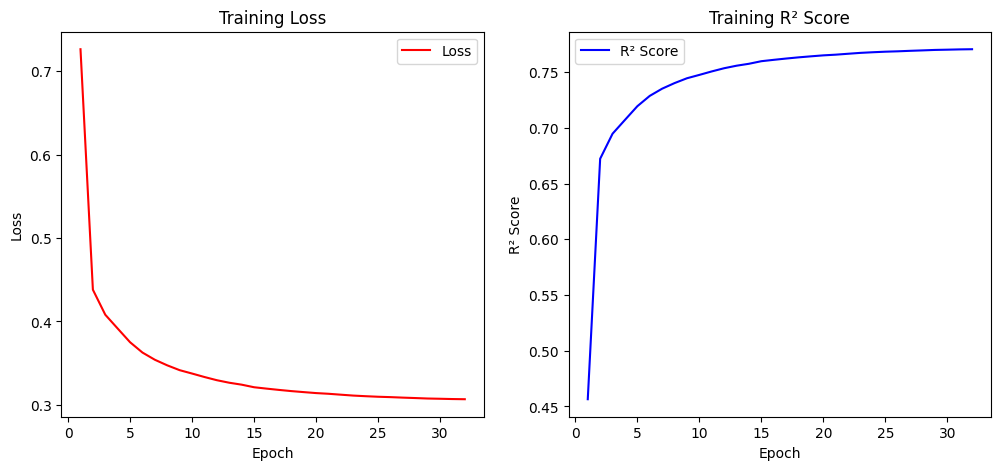

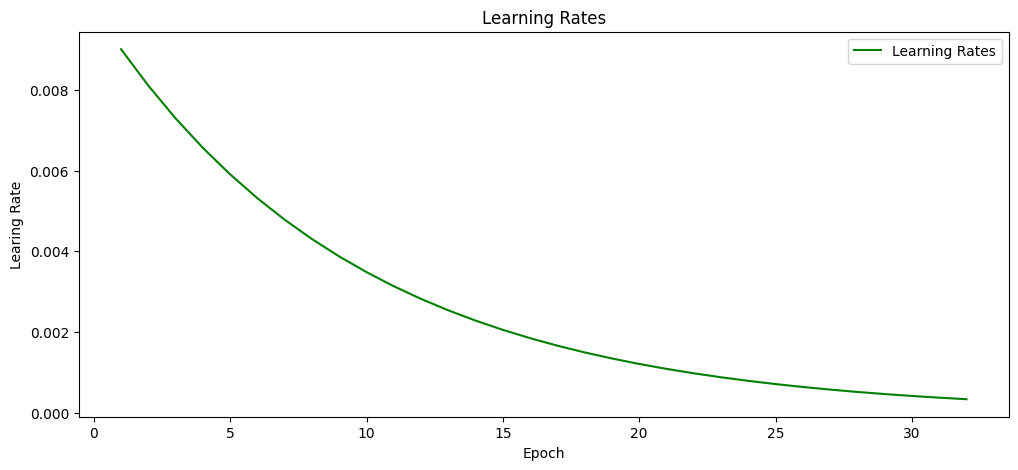

In [14]:
eval_model = HousingModel().to(device)
eval_model.load_state_dict(torch.load('housing_decay.pth'))

mse, r2 = evaluate_regression_model(eval_model, testloader)
print(f"Test MSE: {mse}")
print(f"Test R^2 Score: {r2}")

epochs = range(1, len(epoch_losses) + 1)
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, 'r-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_r2_scores, 'b-', label='R² Score')
plt.title(f'Training R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.show()

plot_learning_rates(epoch_learning_rates)

### Experimental Model

In [15]:
housing_experimental = HousingModel().to(device)
optimizer = optim.SGD(housing_experimental.parameters(), lr=0.1)
criterion = nn.MSELoss()

m, M, T = 7, 30, 2**3
steps = cheb_steps(m, M, T)
perm = cheb_perm(T)   
permuted_steps = steps[perm]

epoch_losses = []
epoch_r2_scores = []
epoch_learning_rates = []

start_time = time.time()

for epoch in range(32):
    epoch_start_time = time.time()
    
    housing_experimental.train()

    lr = permuted_steps[epoch % T]
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    running_loss = 0.0
    predictions_list = []
    labels_list = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = housing_experimental(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions_list.extend(outputs.view(-1).detach().cpu().numpy())
        labels_list.extend(labels.view(-1).detach().cpu().numpy())
    
    epoch_loss = running_loss / len(trainloader)
    epoch_losses.append(epoch_loss)

    
    mse = mean_squared_error(labels_list, predictions_list)
    r2 = r2_score(labels_list, predictions_list)
    epoch_r2_scores.append(r2)
    epoch_learning_rates.append(lr)

    epoch_time = time.time() - epoch_start_time
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, MSE: {mse:.4f}, R^2 Score: {r2:.4f}, Time: {epoch_time:.2f}')

torch.save(housing_experimental.state_dict(), 'housing_experimental.pth')

total_time = time.time() - start_time
print(f'Total training time: {total_time:.2f} seconds')

Epoch 1, Loss: 0.6694, MSE: 0.6694, R^2 Score: 0.4993, Time: 0.90
Epoch 2, Loss: 0.4301, MSE: 0.4301, R^2 Score: 0.6782, Time: 0.86
Epoch 3, Loss: 0.3924, MSE: 0.3924, R^2 Score: 0.7065, Time: 0.87
Epoch 4, Loss: 0.3487, MSE: 0.3487, R^2 Score: 0.7392, Time: 0.89
Epoch 5, Loss: 0.3892, MSE: 0.3892, R^2 Score: 0.7088, Time: 0.97
Epoch 6, Loss: 0.3092, MSE: 0.3092, R^2 Score: 0.7687, Time: 0.94
Epoch 7, Loss: 0.3330, MSE: 0.3330, R^2 Score: 0.7509, Time: 0.93
Epoch 8, Loss: 0.2972, MSE: 0.2972, R^2 Score: 0.7776, Time: 0.93
Epoch 9, Loss: 0.3872, MSE: 0.3872, R^2 Score: 0.7104, Time: 0.93
Epoch 10, Loss: 0.2948, MSE: 0.2948, R^2 Score: 0.7795, Time: 0.94
Epoch 11, Loss: 0.3012, MSE: 0.3012, R^2 Score: 0.7747, Time: 1.00
Epoch 12, Loss: 0.2868, MSE: 0.2868, R^2 Score: 0.7854, Time: 0.93
Epoch 13, Loss: 0.3375, MSE: 0.3375, R^2 Score: 0.7475, Time: 0.95
Epoch 14, Loss: 0.2743, MSE: 0.2743, R^2 Score: 0.7948, Time: 0.93
Epoch 15, Loss: 0.2976, MSE: 0.2976, R^2 Score: 0.7774, Time: 0.95
Epoc

Test MSE: 0.2793790400028229
Test R^2 Score: 0.7868001036532405


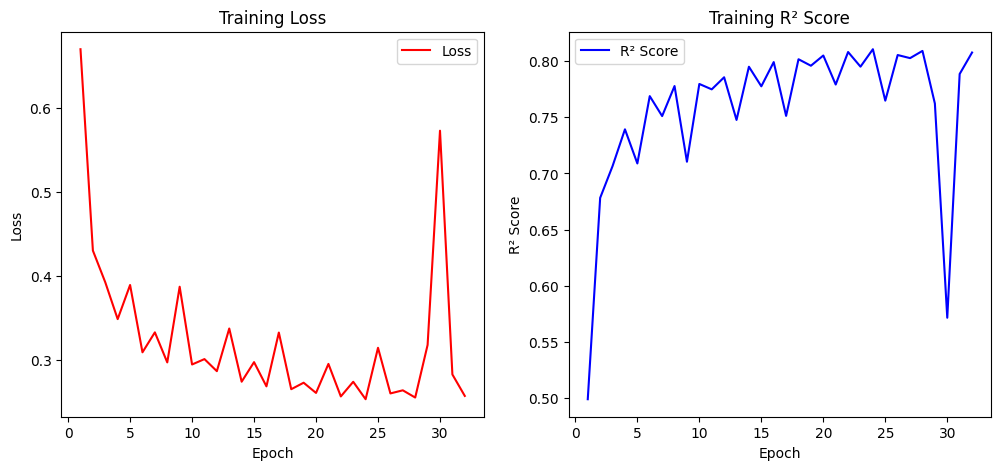

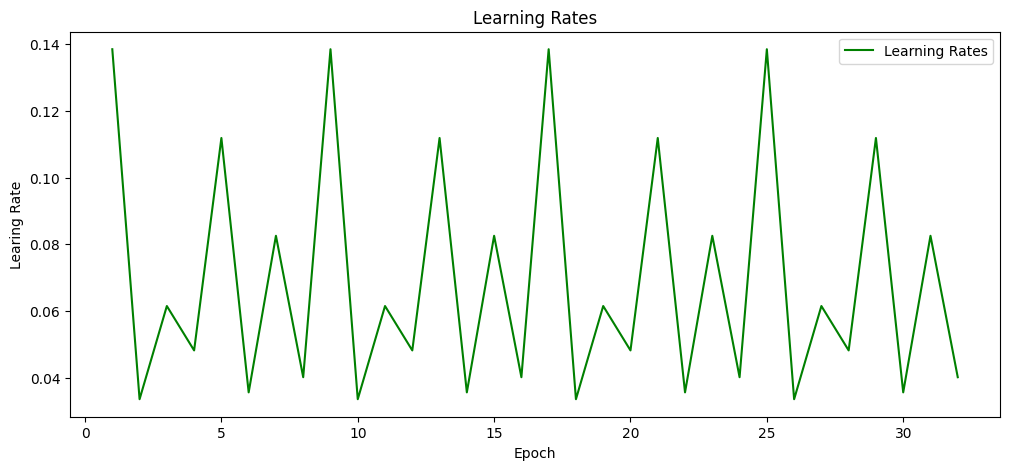

In [16]:
eval_model = HousingModel().to(device)
eval_model.load_state_dict(torch.load('housing_experimental.pth'))

mse, r2 = evaluate_regression_model(eval_model, testloader)
print(f"Test MSE: {mse}")
print(f"Test R^2 Score: {r2}")

epochs = range(1, len(epoch_losses) + 1)
plt.figure(figsize=(12, 5))
    
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, 'r-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_r2_scores, 'b-', label='R² Score')
plt.title(f'Training R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.show()

plot_learning_rates(epoch_learning_rates)